In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pickle
from pathlib import Path

import models

2022-04-21 19:39:33.012105: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 19:39:33.037718: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3699850000 Hz
2022-04-21 19:39:33.038125: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d7737d2c70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-21 19:39:33.038145: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [2]:
cces = pd.read_csv('data/cces_df.csv', index_col=0)
cces_all = pd.read_csv('data/cces_all_df.csv', index_col=0)
cces_weighted = pd.read_csv('data/cces_weighted_df.csv', index_col=0)

In [3]:
cces

,abortion,eth,male,age,educ,repvote,region,state
1,1,White,-0.5,60-69,4-Year College,0.504080,North Central,WI
2,1,White,-0.5,60-69,HS,0.427158,Northeast,NJ
3,0,White,-0.5,40-49,HS,0.506188,South,FL
4,1,White,0.5,70+,Some college,0.506188,South,FL
5,0,White,-0.5,50-59,Some college,0.409799,North Central,IL
...,...,...,...,...,...,...,...,...
4996,0,White,0.5,50-59,4-Year College,0.338718,West,CA
4997,0,White,0.5,18-29,Some college,0.518900,West,AZ
4998,1,White,0.5,50-59,HS,0.473167,West,CO
4999,1,White,-0.5,50-59,HS,0.506188,South,FL


## Transform data

In [4]:
# Fills in the dictionary so that we know which index corresponds to what state / eth / edu etc.

data_to_idx = {}
list_of_states_and_votes = []
list_of_states = []
state = 0
age = 50
eth = 56
educ = 60
male_eth = 65
educ_age = 73
educ_eth = 103
for i in range(1, len(cces_all)+1):
    tup = (cces_all.loc[i,'state'], cces_all.loc[i,'repvote'])
    if cces_all.loc[i,'state'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'state']] = state
        state += 1
    if tup not in list_of_states_and_votes:
        list_of_states_and_votes.append(tup)
    if cces_all.loc[i,'age'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'age']] = age
        age += 1
    if cces_all.loc[i,'eth'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'eth']] = eth
        eth += 1
    if cces_all.loc[i,'educ'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'educ']] = educ
        educ += 1
list_of_states_and_votes.sort(key=lambda x:x[1])
for tup in list_of_states_and_votes:
    list_of_states.append(tup[0])

In [5]:
# Create new representation of data that contains only 0 and 1

def transform_raw(cces, data_to_idx, i, 
                  state=0, age=50, eth=56, educ=60,
                  male_eth=65, educ_age=73, educ_eth=103):
    x_i = np.zeros(128)
    eth_idx = data_to_idx[cces.loc[i,'eth']]
    age_idx = data_to_idx[cces.loc[i,'age']]
    educ_idx = data_to_idx[cces.loc[i,'educ']]
    x_i[data_to_idx[cces.loc[i,'state']]] = 1
    x_i[age_idx] = 1
    x_i[eth_idx] = 1
    x_i[educ_idx] = 1
    
    is_male = int(cces.loc[i,'male'] + 0.5)
    male_eth_idx = male_eth + is_male * 4 + (eth_idx-eth) 
    educ_age_idx = educ_age + (educ_idx-educ) * 6 + (age_idx-age)
    educ_eth_idx = educ_eth + (educ_idx-educ) * 4 + (eth_idx-eth)
    x_i[male_eth_idx] = 1
    x_i[educ_age_idx] = 1
    x_i[educ_eth_idx] = 1
    
    x_i[123] = is_male
    x_i[124] = int(cces.loc[i,'region'] == 'South')
    x_i[125] = int(cces.loc[i,'region'] == 'North Central')
    x_i[126] = int(cces.loc[i,'region'] == 'West')
    x_i[127] = cces.loc[i,'repvote']
    
    return x_i

x = []
y = []
for i in range(1, len(cces)+1):
    x_i = transform_raw(cces, data_to_idx, i)
    
    x.append(x_i)
    y.append(cces.loc[i,'abortion'])

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

## Variational Inference

In [6]:
# model = models.VI_KLqp(dataset='survey', v_fam='flow')
# model.x = x
# model.y = y
# model.train(lr=0.003)

In [7]:
# model = models.VI_KLqp(dataset='survey', v_fam='gaussian')
# model.x = x
# model.y = y
# model.train(lr=0.01)

## Hamiltonian Score Climbing

In [8]:
# model = models.VI_KLpq(v_fam='flow', space='warped', dataset='survey', hmc_e=0.03, hmc_L=33, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.001)

In [9]:
# model = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.05, hmc_L=20, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.01)

In [10]:
# model = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.05, hmc_L=20, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.01, epochs=int(1e4))

In [11]:
# # MSC
# model = models.VI_KLpq(v_fam='gaussian', space='theta', dataset='survey', hmc_e=0.03, hmc_L=33, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.01)

## Real MSC

In [12]:
# #MSC, i-SIR

# model = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.03, hmc_L=33, chains=2, cis=10, eps=0.5, alpha=0.95, rejuvenation=True)
# model.x = x
# model.y = y
# model.train(lr=0.01, epochs=int(1e4))

## Evaluations

In [13]:
poststrat_df = pd.read_csv('data/poststrat_df.csv')
statelevel_predictors_df = pd.read_csv('data/statelevel_predictors.csv', index_col=0)
poststrat_df = poststrat_df.merge(statelevel_predictors_df, how='left', on='state')
mrp_states_df = pd.read_csv('data/mrp_states.csv')
poststrat_df.head()

,state,eth,male,age,educ,n,repvote,region
0,AL,White,-0.5,18-29,No HS,23948,0.643741,South
1,AL,White,-0.5,18-29,HS,59378,0.643741,South
2,AL,White,-0.5,18-29,Some college,104855,0.643741,South
3,AL,White,-0.5,18-29,4-Year College,37066,0.643741,South
4,AL,White,-0.5,18-29,Post-grad,9378,0.643741,South


In [14]:
# Transform raw data into 0-1 vectors:
x_poststrat = []
for i in range(len(poststrat_df)):
    x_i = transform_raw(poststrat_df, data_to_idx, i)
    x_poststrat.append(x_i)
x_poststrat = np.array(x_poststrat, dtype='float32')

In [15]:
def estimate_vi_model_rate(x_poststrat, data_to_idx, model):
    model.x = x_poststrat
    splitted_x = tf.split(model.x, [123, 5], axis=1)
    alpha = model.q.sample(10000)
    term1 = tf.matmul(splitted_x[0], tf.transpose(alpha))
    term2 = model.gamma_0
    term3 = tf.matmul(splitted_x[1], tf.reshape(model.gamma, (5, 1)))
    post_pred_mat = tf.math.sigmoid(tf.squeeze(term1 + term2 + term3))

    return post_pred_mat

def get_se_bernoulli(p, n):
    return np.sqrt(p*(1-p)/n)

In [16]:
# 5,000-person unadjusted sample estimate:
print('mean', np.mean(cces['abortion']))
print('std', get_se_bernoulli(np.mean(cces['abortion']), len(cces)))

mean 0.4314
std 0.007004199311841433


In [17]:
# 60,000-person unadjusted sample estimate:
print('mean', np.mean(cces_all['abortion']))
print('std', get_se_bernoulli(np.mean(cces_all['abortion']), len(cces_all)))

mean 0.4341581675305133
std 0.002026677342749567


In [18]:
# # load model VI KLqp Gaussian
# path = 'results/survey/vi_klqp_gaussian/2021-10-13-172522/'
# model_qp = models.VI_KLqp(dataset='survey', v_fam='gaussian')
# model_qp.x = x
# model_qp.y = y
# model_qp.gamma_0 = np.genfromtxt(path + 'gamma_0.csv', dtype='float32')[-1]
# model_qp.gamma = np.genfromtxt(path + 'gamma.csv', dtype='float32')[-1,:]
# model_qp.phi_m = np.genfromtxt(path + 'phi_m.csv', dtype='float32')[-1,:]
# model_qp.phi_s = np.genfromtxt(path + 'phi_s.csv', dtype='float32')[-1,:]
# model_qp.sigma = np.genfromtxt(path + 'sigma.csv', dtype='float32')[-1,:]
# model_qp.q = tfd.MultivariateNormalDiag(
#               loc=model_qp.phi_m, 
#               scale_diag=model_qp.phi_s)

In [19]:
# losses = -np.genfromtxt(path + 'elbo.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [121]:
v_fam = 'gaussian'
space = 'warped'

tsc_path = sorted(list(Path(f'results/survey/vi_klpq_N0_{space}_{v_fam}').glob('*')))[-1]
N = 20
ex2_warp_path = sorted(list(Path(f'results/survey/vi_klpq_N{N}_{space}_{v_fam}').glob('*')))[-1]
ex2_warp_rao_path = sorted(list(Path(f'results/survey/vi_klpq_N{N}_{space}_{v_fam}_rao').glob('*')))[-1]

In [122]:
# load model VI KLpq Gaussian - HSC
#path = Path('results/survey/vi_klpq_N0_warped_gaussian/2022-04-18-102854')
model_pq = models.VI_KLpq(v_fam=v_fam, space='warped', dataset='survey', hmc_e=0.05, hmc_L=20, chains=1)
model_pq.x = x
model_pq.y = y
model_pq.gamma_0 = np.genfromtxt(tsc_path / 'gamma_0.csv', dtype='float32')[-1]
model_pq.gamma = np.genfromtxt(tsc_path / 'gamma.csv', dtype='float32')[-1,:]
model_pq.phi_m = np.genfromtxt(tsc_path / 'phi_m.csv', dtype='float32')[-1,:]
model_pq.phi_s = np.genfromtxt(tsc_path / 'phi_s.csv', dtype='float32')[-1,:]
model_pq.sigma = np.genfromtxt(tsc_path / 'sigma.csv', dtype='float32')[-1,:]
model_pq.q = tfd.MultivariateNormalDiag(
    loc=model_pq.phi_m, 
    scale_diag=model_pq.phi_s)

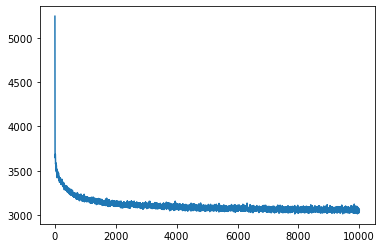

In [123]:
losses = np.genfromtxt(tsc_path / 'losses.csv', dtype='float32')
plt.plot(list(range(len(losses))), losses)

In [124]:
pass # not in warped space

# # load model VI KLpq Gaussian - MSC
# path = Path('results/survey/vi_klpq_N10_eps_gaussian/2022-04-14-180124')
# model_pq_ex2_eps = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.05, hmc_L=20, cis=10, chains=1)
# model_pq_ex2_eps.x = x
# model_pq_ex2_eps.y = y
# model_pq_ex2_eps.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_ex2_eps.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_ex2_eps.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
# model_pq_ex2_eps.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
# model_pq_ex2_eps.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_ex2_eps.q = tfd.MultivariateNormalDiag(
#     loc=model_pq_ex2_eps.phi_m, 
#     scale_diag=model_pq_ex2_eps.phi_s)

In [125]:
# losses = np.genfromtxt(path / 'losses.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [126]:
# load model VI KLpq Gaussian - MSC

model_pq_ex2_warp = models.VI_KLpq(v_fam=v_fam, space='warped', dataset='survey', hmc_e=0.05, hmc_L=20, cis=N, chains=1)
model_pq_ex2_warp.x = x
model_pq_ex2_warp.y = y
model_pq_ex2_warp.gamma_0 = np.genfromtxt(ex2_warp_path / 'gamma_0.csv', dtype='float32')[-1]
model_pq_ex2_warp.gamma = np.genfromtxt(ex2_warp_path / 'gamma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.phi_m = np.genfromtxt(ex2_warp_path / 'phi_m.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.phi_s = np.genfromtxt(ex2_warp_path / 'phi_s.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.sigma = np.genfromtxt(ex2_warp_path / 'sigma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.q = tfd.MultivariateNormalDiag(
    loc=model_pq_ex2_warp.phi_m, 
    scale_diag=model_pq_ex2_warp.phi_s)

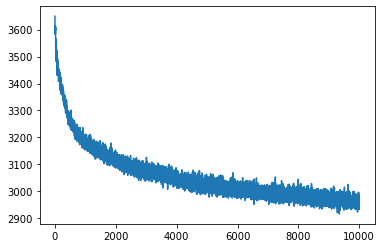

In [127]:
losses = np.genfromtxt(ex2_warp_path / 'losses.csv', dtype='float32')
plt.plot(list(range(len(losses))), losses)

In [128]:
# load model VI KLpq Gaussian - MSC

model_pq_ex2_warp_rao = models.VI_KLpq(v_fam=v_fam, space='warped', dataset='survey', hmc_e=0.05, hmc_L=20, cis=N, chains=1)
model_pq_ex2_warp_rao.x = x
model_pq_ex2_warp_rao.y = y
model_pq_ex2_warp_rao.gamma_0 = np.genfromtxt(ex2_warp_rao_path / 'gamma_0.csv', dtype='float32')[-1]
model_pq_ex2_warp_rao.gamma = np.genfromtxt(ex2_warp_rao_path / 'gamma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp_rao.phi_m = np.genfromtxt(ex2_warp_rao_path / 'phi_m.csv', dtype='float32')[-1,:]
model_pq_ex2_warp_rao.phi_s = np.genfromtxt(ex2_warp_rao_path / 'phi_s.csv', dtype='float32')[-1,:]
model_pq_ex2_warp_rao.sigma = np.genfromtxt(ex2_warp_rao_path / 'sigma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp_rao.q = tfd.MultivariateNormalDiag(
    loc=model_pq_ex2_warp_rao.phi_m, 
    scale_diag=model_pq_ex2_warp_rao.phi_s)

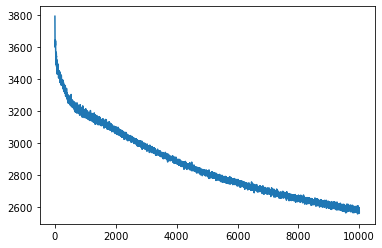

In [129]:
losses = np.genfromtxt(ex2_warp_rao_path / 'losses.csv', dtype='float32')
plt.plot(list(range(len(losses))), losses)

In [81]:
# # load model VI KLqp Flow
# path = 'results/survey/vi_klqp_flow/2021-09-03-223300/'
# model_qp_flow = models.VI_KLqp(v_fam='flow', dataset='survey')
# model_qp_flow.x = x
# model_qp_flow.y = y
# model_qp_flow.gamma_0 = np.genfromtxt(path + 'gamma_0.csv', dtype='float32')[-1]
# model_qp_flow.gamma = np.genfromtxt(path + 'gamma.csv', dtype='float32')[-1,:]
# model_qp_flow.sigma = np.genfromtxt(path + 'sigma.csv', dtype='float32')[-1,:]
# model_qp_flow.load_model(path + 'flow_model/model')

In [82]:
# losses = -np.genfromtxt(path + 'elbo.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [83]:
# # load model VI KLpq Flow
#path = Path('results/survey/vi_klpq_N0_warped_flow/2022-04-18-105801')
# model_pq_flow = models.VI_KLpq(v_fam='flow', space='warped', dataset='survey', hmc_e=0.03, hmc_L=33, chains=64)
# model_pq_flow.x = x
# model_pq_flow.y = y
# model_pq_flow.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_flow.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_flow.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_flow.load_model(path / 'flow_model/model')

In [84]:
# losses = np.genfromtxt(path + 'losses.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [85]:
# load model VI KLpq Flow - MSC
#path = Path('results/survey/vi_klpq_N10_warped_flow/2022-04-15-000944')
# model_pq_ex2_flow_warp = models.VI_KLpq(v_fam='flow', space='eps', dataset='survey', hmc_e=0.03, hmc_L=33, cis=10, chains=1)
# model_pq_ex2_flow_warp.x = x
# model_pq_ex2_flow_warp.y = y
# model_pq_ex2_flow_warp.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_ex2_flow_warp.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_ex2_flow_warp.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
# model_pq_ex2_flow_warp.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
# model_pq_ex2_flow_warp.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_ex2_flow_warp.q = tfd.MultivariateNormalDiag(
#     loc=model_pq_ex2_flow_warp.phi_m, 
#     scale_diag=model_pq_ex2_flow_warp.phi_s)

In [86]:
# losses = np.genfromtxt(path + 'losses.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [87]:
# load model VI KLpq Flow - MSC
#path = Path('results/survey/vi_klpq_N10_warped_flow/2022-04-14-183205')
# model_pq_ex2_warp = models.VI_KLpq(v_fam='flow', space='eps', dataset='survey', hmc_e=0.03, hmc_L=33, cis=10, chains=1)
# model_pq_ex2_warp.x = x
# model_pq_ex2_warp.y = y
# model_pq_ex2_warp.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_ex2_warp.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.q = tfd.MultivariateNormalDiag(
#     loc=model_pq_ex2_warp.phi_m, 
#     scale_diag=model_pq_ex2_warp.phi_s)

In [88]:
# post_pred_mat_qp = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_qp)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

In [89]:
post_pred_mat_pq = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq)
estimate = np.dot(np.array([poststrat_df['n']]), 
                  np.array(post_pred_mat_pq)) / sum(poststrat_df['n'])
print('mean', np.mean(estimate))
print('std', np.std(estimate))

mean 0.43443322537857676
std 0.02312177656006315


In [90]:
# post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_eps)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_pq_msc)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

In [91]:
# post_pred_mat_qp_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp_flow)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_qp_flow)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

In [92]:
pass
# post_pred_mat_pq_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_flow)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_pq_flow)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

Compare parameters under different number of VI samples

In [93]:
# path = 'results/survey/vi_klpq_gaussian/2021-09-01-162133/'
# gamma = np.genfromtxt(path + 'gamma.csv')
# plt.plot(gamma[:,0], label='gamma_1')
# plt.plot(gamma[:,1], label='gamma_2')
# plt.plot(gamma[:,2], label='gamma_3')
# plt.plot(gamma[:,3], label='gamma_4')
# plt.plot(gamma[:,4], label='gamma_5')
# plt.show()

In [94]:
# path = 'results/survey/vi_klpq_gaussian/2021-07-02-164958/'
# gamma_1samp = np.genfromtxt(path + 'gamma.csv')
# plt.plot(gamma_1samp[:,0], label='gamma_1')
# plt.plot(gamma_1samp[:,1], label='gamma_2')
# plt.plot(gamma_1samp[:,2], label='gamma_3')
# plt.plot(gamma_1samp[:,3], label='gamma_4')
# plt.plot(gamma_1samp[:,4], label='gamma_5')
# plt.show()

### By-state predictions

By state

In [95]:
# post_pred_mat_qp = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp)
# state_means_qp = []
# state_stds_qp = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_qp)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_qp.append(np.mean(estimate))
#     state_stds_qp.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_qp = np.array(state_means_qp)
# state_stds_qp = np.array(state_stds_qp)

In [130]:
post_pred_mat_pq = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq)
state_means_pq = []
state_stds_pq = []
for state in list_of_states:
    is_state = np.array([poststrat_df['state'] == state])
    estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
                      np.array(post_pred_mat_pq)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
    state_means_pq.append(np.mean(estimate))
    state_stds_pq.append(np.std(estimate))
    print(state)
    print('mean', np.mean(estimate))
    print('std', np.std(estimate))
state_means_pq = np.array(state_means_pq)
state_stds_pq = np.array(state_stds_pq)

HI
mean 0.3497693309233706
std 0.04605247883231582
CA
mean 0.3809730932274492
std 0.030089494360323814
VT
mean 0.39731807643843
std 0.04699486981117326
MA
mean 0.34224981320296244
std 0.03744537818804156
MD
mean 0.3482219792665956
std 0.037646682015410805
NY
mean 0.3520621752273194
std 0.031698685726634764
IL
mean 0.39871339833278213
std 0.03430865630579485
WA
mean 0.3767161961061436
std 0.03756432371367394
RI
mean 0.37331549743223635
std 0.04607443009384268
NJ
mean 0.3677190511719852
std 0.037297594976267195
CT
mean 0.3502340685144921
std 0.04103675975421285
OR
mean 0.385672114928062
std 0.04196494803816584
DE
mean 0.4458236578459705
std 0.04532676397232933
NM
mean 0.3970438911211068
std 0.041609158358645565
VA
mean 0.43627436288121246
std 0.037150885973724984
CO
mean 0.4089898856477687
std 0.04028409920077255
ME
mean 0.4261081703365289
std 0.047924109244359386
NV
mean 0.39543962044488534
std 0.03979733014259927
MN
mean 0.4270861544016845
std 0.0434196575448962
NH
mean 0.4104686882480

In [97]:
# post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_eps)
# state_means_pq_ex2_eps = []
# state_stds_pq_ex2_eps = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_pq_msc)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_pq_ex2_eps.append(np.mean(estimate))
#     state_stds_pq_ex2_eps.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_pq_msc = np.array(state_means_pq_ex2_eps)
# state_stds_pq_ex2_eps = np.array(state_stds_pq_ex2_eps)

In [131]:
post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_warp)
state_means_pq_ex2_warp = []
state_stds_pq_ex2_warp = []
for state in list_of_states:
    is_state = np.array([poststrat_df['state'] == state])
    estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
                      np.array(post_pred_mat_pq_msc)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
    state_means_pq_ex2_warp.append(np.mean(estimate))
    state_stds_pq_ex2_warp.append(np.std(estimate))
    print(state)
    print('mean', np.mean(estimate))
    print('std', np.std(estimate))
state_means_pq_ex2_warp = np.array(state_means_pq_ex2_warp)
state_stds_pq_ex2_warp = np.array(state_stds_pq_ex2_warp)

HI
mean 0.3609674307375701
std 0.036567212580139084
CA
mean 0.3758683237984134
std 0.023348375456440473
VT
mean 0.386093599847103
std 0.0353176867270749
MA
mean 0.34325951638196567
std 0.028511425520189593
MD
mean 0.35094758361651995
std 0.03062121605515725
NY
mean 0.3545578061543427
std 0.02402774352713947
IL
mean 0.39987045326596476
std 0.02806646805712628
WA
mean 0.3834570726701079
std 0.030363221919299677
RI
mean 0.3706498672062048
std 0.034326637611340034
NJ
mean 0.36875484666780084
std 0.02897766708031229
CT
mean 0.3596215561128088
std 0.03247894217613809
OR
mean 0.39496385946256307
std 0.03264339929977519
DE
mean 0.442559231374059
std 0.03484597971897968
NM
mean 0.40106923818838597
std 0.03384074026128842
VA
mean 0.4327913088590882
std 0.02845842335782888
CO
mean 0.4140695463967906
std 0.03219355577897809
ME
mean 0.42796511883643745
std 0.03516145924345834
NV
mean 0.39929075820850335
std 0.03135565945232496
MN
mean 0.43248058625163005
std 0.032555042485074986
NH
mean 0.419824129

In [132]:
post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_warp_rao)
state_means_pq_ex2_warp_rao = []
state_stds_pq_ex2_warp_rao = []
for state in list_of_states:
    is_state = np.array([poststrat_df['state'] == state])
    estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
                      np.array(post_pred_mat_pq_msc)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
    state_means_pq_ex2_warp_rao.append(np.mean(estimate))
    state_stds_pq_ex2_warp_rao.append(np.std(estimate))
    print(state)
    print('mean', np.mean(estimate))
    print('std', np.std(estimate))
state_means_pq_ex2_warp_rao = np.array(state_means_pq_ex2_warp_rao)
state_stds_pq_ex2_warp_rao = np.array(state_stds_pq_ex2_warp_rao)

HI
mean 0.36327045360803967
std 0.015438697857531387
CA
mean 0.36131757944368953
std 0.011010975785964848
VT
mean 0.37439885029093084
std 0.011727197040697477
MA
mean 0.36305835047354373
std 0.010798953001811615
MD
mean 0.38057759691804116
std 0.010874501660376453
NY
mean 0.36584090751516085
std 0.010469258362903019
IL
mean 0.389834781923013
std 0.010885847028878234
WA
mean 0.39892015441351986
std 0.011410696448238474
RI
mean 0.39289472991691565
std 0.011240685096003344
NJ
mean 0.385444118838691
std 0.010684603104973751
CT
mean 0.39173439768077306
std 0.010964574035872648
OR
mean 0.4141549454364156
std 0.011729752647995702
DE
mean 0.43022890305388245
std 0.011265067661551848
NM
mean 0.41059913456758523
std 0.012049998742767703
VA
mean 0.4382455948882714
std 0.011214967247944426
CO
mean 0.41958788911414513
std 0.011481363344256678
ME
mean 0.43468864726111933
std 0.012392715461178176
NV
mean 0.427495359046224
std 0.011275769574853852
MN
mean 0.43694004255075924
std 0.011959376903792174
N

In [99]:
# post_pred_mat_qp_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp_flow)
# state_means_qp_flow = []
# state_stds_qp_flow = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_qp_flow)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_qp_flow.append(np.mean(estimate))
#     state_stds_qp_flow.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_qp_flow = np.array(state_means_qp_flow)
# state_stds_qp_flow = np.array(state_stds_qp_flow)

In [100]:
pass
# post_pred_mat_pq_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_flow)
# state_means_pq_flow = []
# state_stds_pq_flow = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_pq_flow)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_pq_flow.append(np.mean(estimate))
#     state_stds_pq_flow.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_pq_flow = np.array(state_means_pq_flow)
# state_stds_pq_flow = np.array(state_stds_pq_flow)

In [133]:
state_means_unadj_5000 = []
state_stds_unadj_5000 = []
for state in list_of_states:
    is_state = np.array([cces['state'] == state])
    n = np.sum(is_state)
    mean = np.sum(np.multiply(np.array([cces['abortion']]), is_state))/n
    state_means_unadj_5000.append(mean)
    state_stds_unadj_5000.append(get_se_bernoulli(mean, n))
state_means_unadj_5000 = np.array(state_means_unadj_5000)
state_stds_unadj_5000 = np.array(state_stds_unadj_5000)

In [134]:
state_means_unadj_60000 = []
state_stds_unadj_60000 = []
for state in list_of_states:
    is_state = np.array([cces_all['state'] == state])
    n = np.sum(is_state)
    mean = np.sum(np.multiply(np.array([cces_all['abortion']]), is_state))/n
    state_means_unadj_60000.append(mean)
    state_stds_unadj_60000.append(get_se_bernoulli(mean, n))
state_means_unadj_60000 = np.array(state_means_unadj_60000)
state_stds_unadj_60000 = np.array(state_stds_unadj_60000)

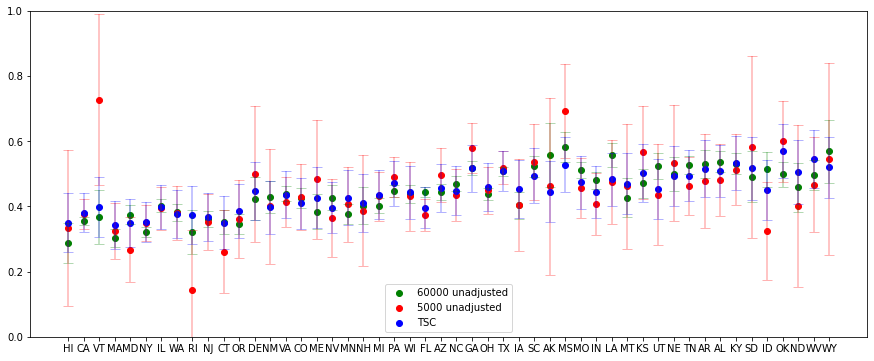

In [135]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_unadj_5000, color='r', label='5000 unadjusted')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')


plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_unadj_5000, 
             yerr=1.96*state_stds_unadj_5000, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)

plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_unadj.png')
plt.show()

In [136]:
# plt.figure(figsize=(15, 6))
# plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
# plt.scatter(list_of_states, state_means_pq_ex2_eps, color='black', label=r'Ex$^2$MCMC, space=eps')
# plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
# plt.errorbar(list_of_states, 
#              state_means_unadj_60000, 
#              yerr=1.96*state_stds_unadj_60000, 
#              linestyle='', color='g', alpha=0.3, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq_ex2_eps, 
#              yerr=1.96*state_stds_pq_ex2_eps, 
#              linestyle='', color='black', alpha=0.3, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq, 
#              yerr=1.96*state_stds_pq, 
#              linestyle='', color='b', alpha=0.3, capsize=5.0)
# plt.ylim(0, 1)
# plt.legend()
# plt.savefig(Path('figs') / 'survey_tsc_ex2_eps.png')
# plt.show()

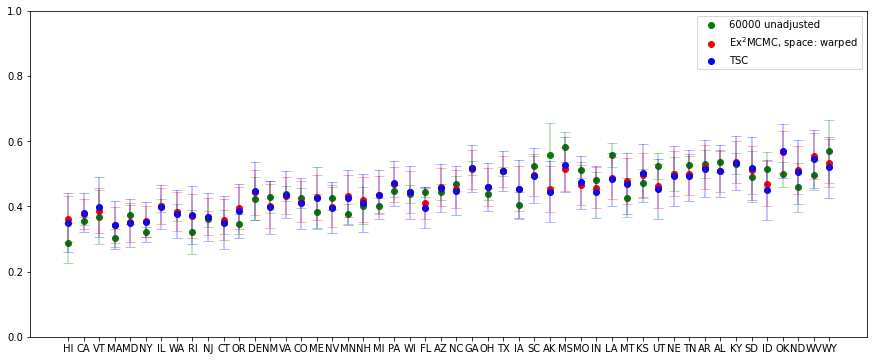

In [137]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_pq_ex2_warp, color='red', label=fr'Ex$^2$MCMC, space: {space}')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq_ex2_warp, 
             yerr=1.96*state_stds_pq_ex2_warp, 
             linestyle='', color='red', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / f'survey_tsc_ex2_{space}.png')
plt.show()

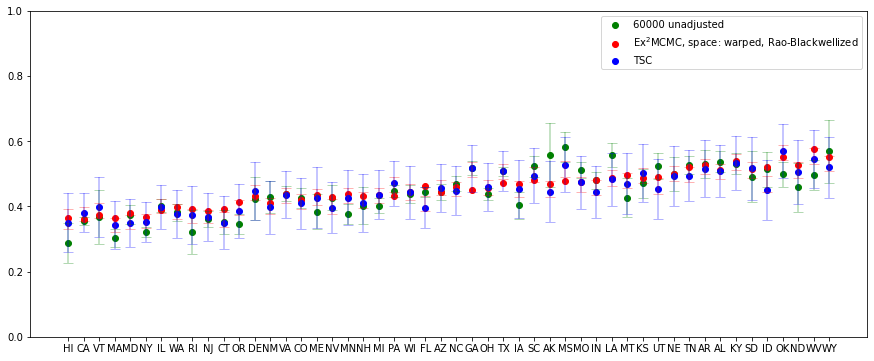

In [139]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_pq_ex2_warp_rao, color='red', label=fr'Ex$^2$MCMC, space: {space}, Rao-Blackwellized')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq_ex2_warp, 
             yerr=1.96*state_stds_pq_ex2_warp_rao, 
             linestyle='', color='red', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / f'survey_tsc_ex2_{space}_rao.png')
plt.show()

In [140]:
pass # TSC Flow

# plt.figure(figsize=(15, 6))
# plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
# #plt.scatter(list_of_states, state_means_qp_flow, color='r', label='VI with flow')
# plt.scatter(list_of_states, state_means_pq_flow, color='b', label='TSC with flow')
# plt.errorbar(list_of_states, 
#              state_means_unadj_60000, 
#              yerr=1.96*state_stds_unadj_60000, 
#              linestyle='', color='g', alpha=0.0, capsize=5.0)
# # plt.errorbar(list_of_states, 
# #              state_means_qp_flow, 
# #              yerr=1.96*state_stds_qp_flow, 
# #              linestyle='', color='r', alpha=0.3, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq_flow, 
#              yerr=1.96*state_stds_pq_flow, 
#              linestyle='', color='b', alpha=0.3, capsize=5.0)
# plt.ylim(0, 1)
# plt.legend()
# plt.savefig(Path('figs') / 'survey_tsc_vi.png')
# plt.show()

In [141]:
# VI

# plt.figure(figsize=(15, 6))
# plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
# #plt.scatter(list_of_states, state_means_qp, color='r', label='VI with Gaussian')
# plt.scatter(list_of_states, state_means_pq, color='b', label='HSC with Gaussian')
# plt.errorbar(list_of_states, 
#              state_means_unadj_60000, 
#              yerr=1.96*state_stds_unadj_60000, 
#              linestyle='', color='g', alpha=0.2, capsize=5.0)
# # plt.errorbar(list_of_states, 
# #              state_means_qp, 
# #              yerr=1.96*state_stds_qp, 
# #              linestyle='', color='r', alpha=0.3, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq, 
#              yerr=1.96*state_stds_pq, 
#              linestyle='', color='b', alpha=0.3, capsize=5.0)
# plt.ylim(0, 1)
# plt.legend()
# plt.savefig(Path('figs') / 'survey_tsc_vi.png')
# plt.show()

In [142]:
pass # HSC Flow

# plt.figure(figsize=(15, 6))
# plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
# plt.scatter(list_of_states, state_means_pq_flow, color='r', label='HSC with Flow')
# plt.scatter(list_of_states, state_means_pq, color='b', label='HSC')
# plt.errorbar(list_of_states, 
#              state_means_unadj_60000, 
#              yerr=1.96*state_stds_unadj_60000, 
#              linestyle='', color='g', alpha=0.2, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq_flow, 
#              yerr=1.96*state_stds_pq_flow, 
#              linestyle='', color='r', alpha=0.7, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq, 
#              yerr=1.96*state_stds_pq, 
#              linestyle='', color='b', alpha=0.7, capsize=5.0)
# plt.ylim(0, 1)
# plt.legend()
# plt.show()

In [143]:
state_means_mrp = []
state_stds_mrp = []
for state in list_of_states:
    idx = mrp_states_df[mrp_states_df['state'] == state].index[0]
    state_means_mrp.append(mrp_states_df.loc[idx, 'mrp_estimate'])
    state_stds_mrp.append(mrp_states_df.loc[idx, 'mrp_estimate_se'])
state_means_mrp = np.array(state_means_mrp)
state_stds_mrp = np.array(state_stds_mrp)

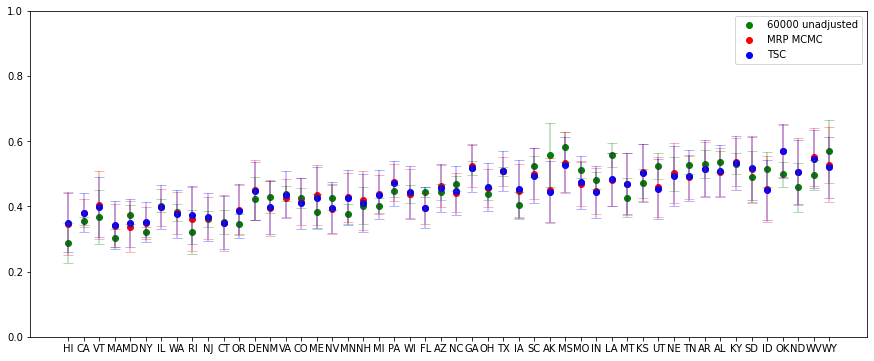

In [144]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_mrp, color='r', label='MRP MCMC')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_mrp, 
             yerr=1.96*state_stds_mrp, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_mrp.png')
plt.show()

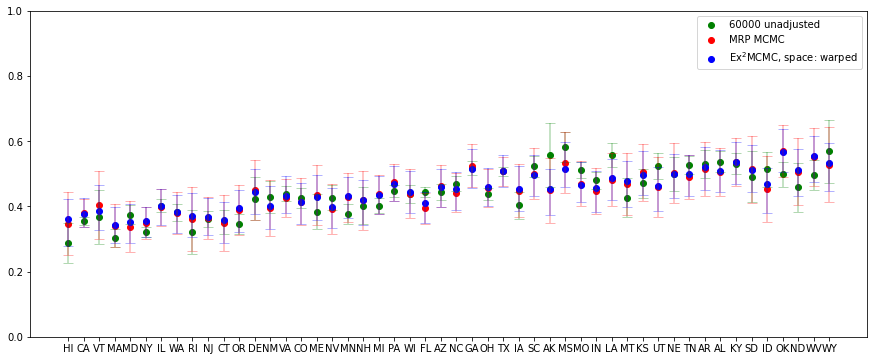

In [145]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_mrp, color='r', label='MRP MCMC')
plt.scatter(list_of_states, state_means_pq_ex2_warp, color='b', label=fr'Ex$^2$MCMC, space: {space}')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_mrp, 
             yerr=1.96*state_stds_mrp, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq_ex2_warp, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / f'survey_ex2_{space}_mrp.png')
plt.show()

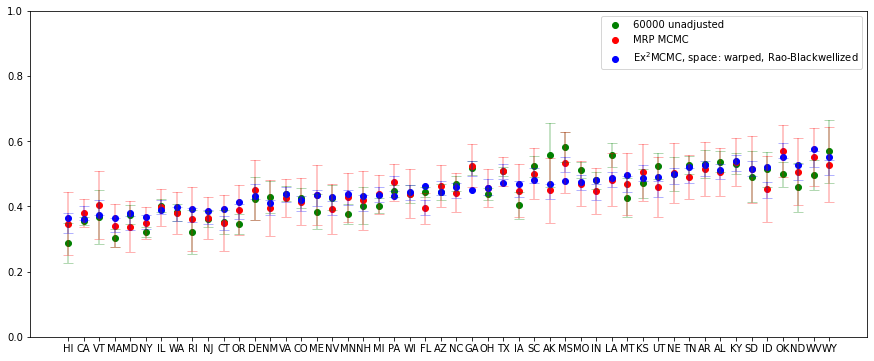

In [146]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_mrp, color='r', label='MRP MCMC')
plt.scatter(list_of_states, state_means_pq_ex2_warp_rao, color='b', label=fr'Ex$^2$MCMC, space: {space}, Rao-Blackwellized')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_mrp, 
             yerr=1.96*state_stds_mrp, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq_ex2_warp_rao, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / f'survey_ex2_{space}_mrp.png')
plt.show()

In [147]:
# print(np.sum((state_stds_pq-state_stds_mrp)**2))
# print(np.sum((state_stds_qp-state_stds_mrp)**2))

# print(np.sum((state_means_pq-state_means_mrp)**2))
# print(np.sum((state_means_qp-state_means_mrp)**2))

### Effective sample size

In [148]:
hmc_points_tsc = np.squeeze(np.array(pd.read_pickle(tsc_path /'hmc_points.pickle')))
hmc_points_ex2_warp = np.squeeze(np.array(pd.read_pickle(ex2_warp_path / 'hmc_points.pickle')))
hmc_points_ex2_warp_rao = np.squeeze(np.array(pd.read_pickle(ex2_warp_rao_path / 'hmc_points.pickle')))

In [149]:
def autocor(x, t):
    n = x.shape[0]
    mu = np.mean(x, axis=0)
    sigma2 = np.var(x, axis=0)
    numer = np.sum((x[:(n-t),:]-mu) * (x[t:,:]-mu), axis=0)
    return numer/((n-t)*sigma2)

def neff(x):
    n = x.shape[0]
    d = x.shape[1]
    autocor_arr = np.zeros((n, d))
    dim_to_set_to_0 = []
    for t in range(1, n):
        autocor_arr[t-1,:] = autocor(x, t)
        if len(dim_to_set_to_0) > 0:
            autocor_arr[t-1, dim_to_set_to_0] = 0
        if t > 1:
            for d_i in range(d):
                if autocor_arr[t-1, d_i] + autocor_arr[t-2, d_i] < 0:
                    autocor_arr[t-1, d_i] = 0
                    autocor_arr[t-2, d_i] = 0
                    if d_i not in dim_to_set_to_0:
                        dim_to_set_to_0.append(d_i)
            if len(dim_to_set_to_0) == d:
                break
    return n/(1+2*np.sum(autocor_arr, axis=0))

In [150]:
list_of_checkpt = [500, 1000, 2000, 5000, 10000] #, 20000, 30000, 50000, 100000]
num_dim = hmc_points_tsc.shape[1]
neff_list_ex2_warp = np.zeros((len(list_of_checkpt), num_dim))

for i in range(len(list_of_checkpt)):
    idx = list_of_checkpt[i]
    neff_list_ex2_warp[i, :] = neff(hmc_points_ex2_warp[:idx, :])
    print(i, np.mean(neff_list_ex2_warp[i,:]/idx))

0 0.12056227851225085
1 0.10987926615879824
2 0.10475345277534073
3 0.10575799694883076
4 0.10938319459609418


In [151]:
list_of_checkpt = [500, 1000, 2000, 5000, 10000] #, 20000, 30000, 50000, 100000]
num_dim = hmc_points_tsc.shape[1]
neff_list_ex2_warp_rao = np.zeros((len(list_of_checkpt), num_dim))

for i in range(len(list_of_checkpt)):
    idx = list_of_checkpt[i]
    neff_list_ex2_warp_rao[i, :] = neff(hmc_points_ex2_warp_rao[:idx, :])
    print(i, np.mean(neff_list_ex2_warp_rao[i,:]/idx))

0 0.12084213228718658
1 0.11356433150765753
2 0.1034494227936694
3 0.07790795982080034
4 0.06632075994858459


In [117]:
neff_list_tsc = np.zeros((len(list_of_checkpt), num_dim))

for i in range(len(list_of_checkpt)):
    idx = list_of_checkpt[i]
    neff_list_tsc[i, :] = neff(hmc_points_tsc[:idx, :])
    print(i, np.mean(neff_list_tsc[i,:]/idx))

0 0.11442116784158353
1 0.10079683656785997
2 0.09429095674462086
3 0.09266899854655342
4 0.09452942423417489


In [152]:
np.savetxt('results/neff_list_tsc.csv', neff_list_tsc)
np.savetxt('results/neff_list_ex2_warp.csv', neff_list_ex2_warp)
np.savetxt('results/neff_list_ex2_warp_rao.csv', neff_list_ex2_warp_rao)

In [153]:
neff_list_tsc = np.genfromtxt('results/neff_list_tsc.csv')
neff_list_ex2_warp = np.genfromtxt('results/neff_list_ex2_warp.csv')
neff_list_ex2_warp_rao = np.genfromtxt('results/neff_list_ex2_warp_rao.csv')
list_of_checkpt = [500, 1000, 2000, 5000, 10000] #, 20000, 30000, 50000, 100000]

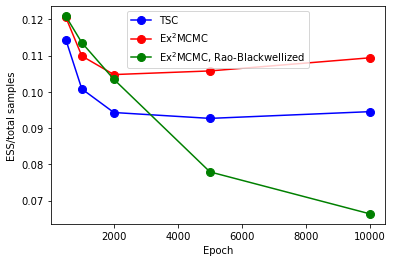

In [154]:
import matplotlib.pylab as pylab

# params = {'legend.fontsize': 'x-large',
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
# pylab.rcParams.update(params)

plt.plot(list_of_checkpt, 
         np.mean(neff_list_tsc, axis=1)/np.array(list_of_checkpt),
         marker='o', markersize=8, color='b',
         label='TSC')
plt.plot(list_of_checkpt, 
         np.mean(neff_list_ex2_warp, axis=1)/np.array(list_of_checkpt),
         marker='o', markersize=8, color='r',
         label=r'Ex$^2$MCMC')
plt.plot(list_of_checkpt, 
         np.mean(neff_list_ex2_warp_rao, axis=1)/np.array(list_of_checkpt),
         marker='o', markersize=8, color='g',
         label=r'Ex$^2$MCMC, Rao-Blackwellized')

plt.legend()
plt.ylabel('ESS/total samples')
plt.xlabel('Epoch')
plt.savefig(Path('figs') / 'survey_ess.png')

# THE END

## Transform Weighted Data and Run Methods

In [ ]:
x_weighted = []
y_weighted = []
state = 0
age = 50
eth = 56
educ = 60
male_eth = 65
educ_age = 73
educ_eth = 103
for i in range(1, len(cces)+1):
    x_i = np.zeros(128)
    eth_idx = data_to_idx[cces_weighted.loc[i,'eth']]
    age_idx = data_to_idx[cces_weighted.loc[i,'age']]
    educ_idx = data_to_idx[cces_weighted.loc[i,'educ']]
    x_i[data_to_idx[cces_weighted.loc[i,'state.x']]] = 1
    x_i[age_idx] = 1
    x_i[eth_idx] = 1
    x_i[educ_idx] = 1
    
    is_male = int(cces_weighted.loc[i,'male'] + 0.5)
    male_eth_idx = male_eth + is_male * 4 + (eth_idx-eth) 
    educ_age_idx = educ_age + (educ_idx-educ) * 6 + (age_idx-age)
    educ_eth_idx = educ_eth + (educ_idx-educ) * 4 + (eth_idx-eth)
    x_i[male_eth_idx] = 1
    x_i[educ_age_idx] = 1
    x_i[educ_eth_idx] = 1
    
    x_i[123] = is_male
    x_i[124] = int(cces_weighted.loc[i,'region'] == 'South')
    x_i[125] = int(cces_weighted.loc[i,'region'] == 'North Central')
    x_i[126] = int(cces_weighted.loc[i,'region'] == 'West')
    x_i[127] = cces_weighted.loc[i,'repvote']
    
    x_weighted.append(x_i)
    y_weighted.append(cces_weighted.loc[i,'abortion'])

x_weighted = np.array(x_weighted, dtype=np.float32)
y_weighted = np.array(y_weighted, dtype=np.float32)

In [ ]:
tf.nn.sigmoid_cross_entropy_with_logits(logits=[[1.,9.],[1.,9.]], labels=[[0.,1.],[1.,0.]])


Define a variational distribution q(alpha; phi) \
Define probabilistic model p(y|alpha; x, theta) \
Define prior p(alpha; theta) \
phi and theta are trainable by gradient methods \
\
for batch_x in x: 
   * sample alpha from q 
   * compute logpx_z = log p(y|alpha; batch_x, theta) 
   * compute logpz = log p(z; theta) 
   * compute logqz_x = log q(alpha; phi) 
   * elbo = logpx_z + logpz - logqz_x 
   * input -elbo as the objective into the autodiff. function
    
How to define q(alpha; phi):
* Gaussian with diagonal covariance
* In a separate implementation, q can also be a flow-based dist.

How to define p(alpha; theta):
* A number of Gaussian, same as in the document

How to define p(y|alpha; x, theta):
* The goal is that p(y|...) = inv_logit(alpha_1 + ... + alpha_m)
* Note that we do not want to loop over x, and decide which 
  alpha (like which state/education level) does that x_i belong to
* Map x to a multi-hot vector v, which is sparse, and element-wise 
  multiply v with alpha (like turning on and off which alpha_i is 
  relevant)


Define a variational distribution q(alpha; phi) \
Define probabilistic model p(y|alpha; x, theta) \
Define prior p(alpha; theta) \
Define HMC target p(alpha|y; theta) or p(eps|y; theta) \
phi and theta are trainable by gradient methods

for batch_x in x:

How to define p(alpha|y; theta):
* p(alpha|y; theta) is proportional to p(alpha; theta) p(y|alpha; x, theta)

In [ ]:
import pickle
import pandas as pd

In [ ]:
a = np.reshape(np.array(list(range(24))), (2,3,4))

with open('abc.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
pd.read_pickle('abc.pickle')


In [ ]:
def autocor(x, t):
    n = x.shape[0]
    mu = np.mean(x)
    sigma2 = np.var(x)
    numer = np.sum((x[:(n-t),:]-mu) * (x[t:,:]-mu))
    return numer/((n-t)*sigma2)

def neff(x):
    n = x.shape[0]
    d = x.shape[1]
    d_i = 0
    autocor_arr = np.zeros((n, d))
    for t in range(1, n):
        autocor_arr[t-1, :] = autocor(x, t)
        if t > 1:
            if autocor_arr[t-1, d_i] + autocor_arr[t-2, d_i] < 0:
                autocor_arr[t-1, d_i] = 0
                autocor_arr[t-2, d_i] = 0
                break      
    return n/(1+2*np.sum(autocor_arr))

space_btw_epochs = 1000
num_checkpt = int(hmc_points_warped.shape[0] / space_btw_epochs)
num_dim = hmc_points_warped.shape[1]
neff_list_orig = np.zeros((num_checkpt, num_dim))

for i in range(num_checkpt):
    idx = space_btw_epochs * (i+1)
    neff_list_orig[i, :] = neff(hmc_points_orig[:idx, :])
    print(i, np.mean(neff_list_orig[i,:]/idx))